#  Example - Interacting with External Beam Plans

Here we will have a look at an external beam plan, perform a manual calculation of the dose and compare it against the dose in the dose file. 

In the resources folder we have a patient with a CT dataset, a plan object, a structure set, and a dose object.

In [1]:
import pydicom as pd

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

## The patient
For some quick context - the "patient" is a big block of water, the CT dataset is actually blank and the "patient" is created from the structure set

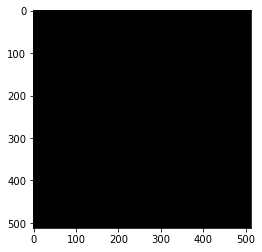

In [4]:
ds_CTslice = pd.dcmread("resources/CT.1.2.246.352.221.5382605522286759600.12162106804760275885.dcm")
plt.imshow(ds_CTslice.pixel_array,cmap=plt.cm.bone)

## Back to the plan...
We will load the plan and show the information

In [5]:
ds_rtplan = pd.dcmread("resources/RP.1.2.246.352.221.5446671153178189143.3115329015485527700.dcm")

In [6]:
ds_rtplan

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 192
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: RT Plan Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.246.352.221.5446671153178189143.3115329015485527700
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.246.352.70.2.1.160.3
(0002, 0013) Implementation Version Name         SH: 'DCIE 16.1'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0012) Instance Creation Date              DA: '20220715'
(0008, 0013) Instance Creation Time              TM: '102008'
(0008, 0016) SOP Class UID                       UI: RT Plan Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.246.352.221.5446671153178189143.3115329015485527700
(0008, 0

Next lets check for the number of beams and load them

In [7]:
print("We can count the number of Beam Sequences: " +  str(len((ds_rtplan.BeamSequence))))

We can count the number of Beam Sequences: 1


In our example plan, there is only one beam - so let's see the relevant detail. 

**Note**: for details on the units involved, see:  
[Table C.8-46: RT Prescription Module Attributes](https://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_c.8.8.10.html)  
[Table C.8-50: RT Beams Module Attributes](https://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.8.8.21.html)

In [8]:
print(ds_rtplan.BeamSequence)

[(0008, 0070) Manufacturer                        LO: 'Varian Medical Systems'
(0008, 1090) Manufacturer's Model Name           LO: 'TDS'
(3002, 0050)  Primary Fluence Mode Sequence  1 item(s) ---- 
   (3002, 0051) Fluence Mode                        CS: 'STANDARD'
   ---------
(300a, 00b2) Treatment Machine Name              SH: 'TRF_18'
(300a, 00b3) Primary Dosimeter Unit              CS: 'MU'
(300a, 00b4) Source-Axis Distance                DS: '1000.0'
(300a, 00b6)  Beam Limiting Device Sequence  2 item(s) ---- 
   (300a, 00b8) RT Beam Limiting Device Type        CS: 'X'
   (300a, 00bc) Number of Leaf/Jaw Pairs            IS: '1'
   ---------
   (300a, 00b8) RT Beam Limiting Device Type        CS: 'Y'
   (300a, 00bc) Number of Leaf/Jaw Pairs            IS: '1'
   ---------
(300a, 00c0) Beam Number                         IS: '1'
(300a, 00c2) Beam Name                           LO: 'Field 1'
(300a, 00c4) Beam Type                           CS: 'STATIC'
(300a, 00c6) Radiation Type   

At this point, with the above information, it'd be useful to draw a diagram of the setup.

Hint: if you are unsure of the name of a specific tag in pydicom you can use the following syntax to see related results `ds_rtplan.dir("searchterm")`, example below.

In [9]:
ds_rtplan.dir("Plan")

['PlanIntent',
 'RTPlanDate',
 'RTPlanGeometry',
 'RTPlanLabel',
 'RTPlanName',
 'RTPlanTime']

For our patient, we can see the pertinent information.

For this patient:

| Item | Source | Value |
| ----- | -------------- | ----- |
| Prescription Reference | (300a, 0016) Dose Reference Description | 'zz_6cm'|
| Reference Point Coordinates | (300a, 0018) Dose Reference Point Coordinates | [0, -40, 0] |
| Isocentre position | (300a, 012c) Isocenter Position | [0, -100, 1.7763568394e-14] |
| Target Prescription Dose | (300a, 0026) Target Prescription Dose  | 36.0 |
| Target Prescription Units | Table C.8-46 | Gy |

For the specific fraction:

| Item | Source | Value |
| ----- | -------------- | ----- |
| Dose | (300a, 0084) Beam Dose | 3.0 |
| Beam Meterset (i.e. MU) | (300a, 0086) Beam Meterset | 367.670378557074 | 

For the specific beam:

| Item | Source | Value |
| ---- | ------ | ----- |
| Beam Limiting Device 1 | (300a, 00b8) RT Beam Limiting Device Type | X |
| Beam Limiting Device 1 - Leaf/Jaw Positions | (300a, 011c) Leaf/Jaw Positions | -35, 35 * |
| Beam Limiting Device 2 | (300a, 00b8) RT Beam Limiting Device Type | Y |
| Beam Limiting Device 2 - Leaf/Jaw Positions | (300a, 011c) Leaf/Jaw Positions | -20, 20 * |
| Energy | (300a, 0114) Nominal Beam Energy | 10 |
| Energy Unit | Table C.8-50 | MV |

* For aymmetric fields, you may need to determine the coordinate system to know which beam limiting device side moves in which direction. For this case it doesn't really matter.

# Calculation
Now we just need to perform the calculation.

From our lectures we know for a 100cm FSD beam, we can reduce the manual calculation to  $MU = \frac{d X R}{PDD}$. We therefore need to work out d, R and PDD.

d is given from prescription dose for the fraction, and is 3 Gy.

To work out R and PDD, we first need the equivalent square. From the beam limiting devices we can see that it is a 70mm by 40mm field, therefore it's equivalent square will be:

In [10]:
(2 * 70 * 40)/(70 + 40)

50.90909090909091

51 x 51 mm, or 5.1 x 5.1 cm

The source axis distance is 1000mm, or 100cm, so our standard PDD tables will be fine. For the PDDs, see [PDD pdf](./resources/PDDs.pdf), and for relative outputs, see [output factors pdf](./resources/outputfactors.pdf)

Together then, we know it is a 10MV beam at 100cm FSD, at 5.1 equivalent square field. We therefore use the second set of tables in the PDDs, and in the output factors. 

From the details pulled out above we can see the reference dose point coordinates at at [0, -40, 0] and the isocentre is (for all intents and purposes) at [0, -100, 0]. The difference is 60mm, which ties up with our dose reference point label of zz_6cm, therefore we need to get a PDD for 6cm deep.

Using the second table, for a depth of 6cm, we can pull out the 5cm equivalent square PDD as 87.0 and for 6cm as 87.2. We could interpolate between the two, but it'll be very close to 87.0 so we can just use that for now.

From the output factors for 10MV, at 100cm deep, we can see that for an equivalent square of 5cm the output factor is 106.9, and for 6cm is 104.8. We can therefore interpolate to get the factor for 5.1cm. We can use the formula $\frac{y-y_0}{x-x_0} = \frac{y_1-y_0}{x_1-x_0}$. Conveniently numpy has an interpolation function.

In [11]:
np.interp(5.1,[5,6],[106.9,104.8])

106.69000000000001

So we have R as 106.7, PDD as 87.0, and d as 3 Gy. Together this gives an MU of:

In [12]:
(3*106.7)/87.0

3.6793103448275866

Comparing that against the meterset, we notice something wrong: we are a factor of 100 out! Remember back to lectures that we calibrate our outputs as 1MU/cGy! So if we instead convert to cGy first, we get:

In [13]:
(300*106.7)/87.0

367.9310344827586

Which pretty much matches out Beam Meterset!